# AlexNet

In [16]:
#torch
import torch 
import torch.nn as nn
import torch.optim as optim  
import torchvision

import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import Compose, ToTensor, Resize
from torchvision.datasets import ImageFolder
from torch.utils.data import (
    Dataset,
    DataLoader,
    Subset
) 

# other
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import warnings
from skimage import io
# from PIL import Image
import time

warnings.filterwarnings("ignore")

from helper_evaluation import set_all_seeds, set_deterministic, compute_confusion_matrix, compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_dataset import get_dataloaders_cifar10, UnNormalize

from data_loading_functions import split_train_test_loaders, show_img

# Load Data and Preprocessing 

In [2]:
dataset_path = '.\\Combined_data'
datas, train_loader, valid_loader, test_loader = split_train_test_loaders(dataset_path)

# Display Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
train data
actual labels: ['COVID', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']
numerical labels: tensor([0, 1, 3, 0])


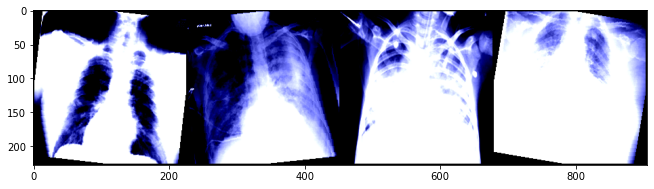

In [3]:
print('train data')
show_img(datas[0])

In [4]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([2, 1, 3, 0, 2, 0, 2, 2, 3, 0])

Validation Set:
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([0, 2, 3, 1, 3, 1, 1, 1, 2, 1])

Testing Set:
Image batch dimensions: torch.Size([64, 3, 224, 224])
Image label dimensions: torch.Size([64])
tensor([2, 1, 3, 3, 0, 2, 1, 2, 2, 0])


In [5]:
print(f'Length of Training: {len(datas[0])}')
print(f'Length of Validation: {len(datas[1])}')
print(f'Length of Testing: {len(datas[2])}')

Length of Training: 21658
Length of Validation: 2708
Length of Testing: 2707


# AlexNet

## Settings

In [6]:
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.0005
BATCH_SIZE = 64
NUM_EPOCHS = 20

# Architecture
NUM_FEATURES = 224*224
NUM_CLASSES = 4

# Other
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
GRAYSCALE = False

## From Scratch AlexNet

In [24]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)
        return logits

In [25]:
torch.manual_seed(RANDOM_SEED)

model_scratch = AlexNet(NUM_CLASSES)
model_scratch.to(DEVICE)

optimizer_scratch = torch.optim.Adam(model_scratch.parameters(), lr=LEARNING_RATE)  

## Train (Scratch AlexNet)

In [7]:
minibatch_loss_list_scratch, train_acc_list_scratch, valid_acc_list_scratch = train_model(num_epochs = NUM_EPOCHS, model = model_scratch, 
                                                                optimizer = optimizer_scratch, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

NameError: name 'model_scratch' is not defined

# Evaluation (Scratch AlexNet)

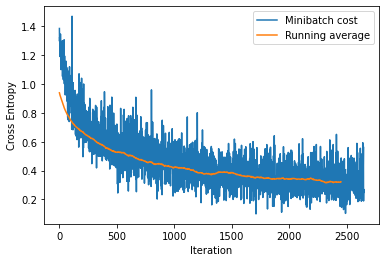

In [38]:
plt.plot(minibatch_loss_list_scratch, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_scratch, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

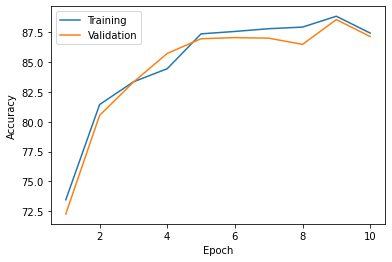

In [39]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_scratch, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_scratch, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 87.34%
Validation ACC: 87.34%
Test ACC: 87.43%


# PreTrained AlexNet (framework only)

In [8]:
model = torchvision.models.alexnet(pretrained=True)

model.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
torch.manual_seed(RANDOM_SEED)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

In [10]:
minibatch_loss_list, train_acc_list, valid_acc_list = train_model(num_epochs = NUM_EPOCHS, model = model, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/010 | Batch 0000/0339 | Loss: 1.4177
Epoch: 001/010 | Batch 0050/0339 | Loss: 1.0539
Epoch: 001/010 | Batch 0100/0339 | Loss: 0.7592
Epoch: 001/010 | Batch 0150/0339 | Loss: 0.8194
Epoch: 001/010 | Batch 0200/0339 | Loss: 0.6750
Epoch: 001/010 | Batch 0250/0339 | Loss: 0.6599
Epoch: 001/010 | Batch 0300/0339 | Loss: 0.5835
Epoch: 001/010 | Train: 73.24% | Validation: 73.08%
Time elapsed: 17.86 min
Epoch: 002/010 | Batch 0000/0339 | Loss: 0.9155
Epoch: 002/010 | Batch 0050/0339 | Loss: 0.9819
Epoch: 002/010 | Batch 0100/0339 | Loss: 0.5840
Epoch: 002/010 | Batch 0150/0339 | Loss: 0.5252
Epoch: 002/010 | Batch 0200/0339 | Loss: 0.3851
Epoch: 002/010 | Batch 0250/0339 | Loss: 0.5754
Epoch: 002/010 | Batch 0300/0339 | Loss: 0.4423
Epoch: 002/010 | Train: 81.66% | Validation: 81.98%
Time elapsed: 33.62 min
Epoch: 003/010 | Batch 0000/0339 | Loss: 0.5866
Epoch: 003/010 | Batch 0050/0339 | Loss: 0.4893
Epoch: 003/010 | Batch 0100/0339 | Loss: 0.5079
Epoch: 003/010 | Batch 0150/0339

# Evaluation (PreTrained AlexNet, framework only)

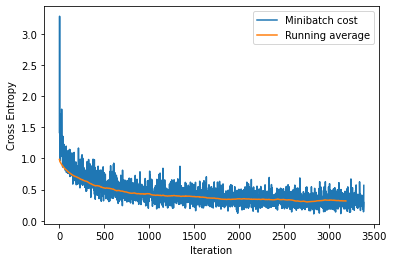

In [13]:
plt.plot(minibatch_loss_list, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

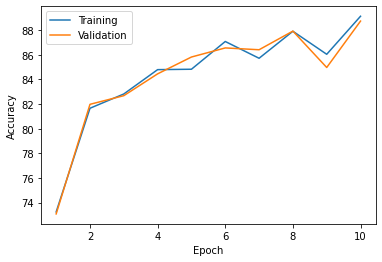

In [14]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [17]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 89.19%
Validation ACC: 89.33%
Test ACC: 87.85%


# Pretrained AlexNet: fine tuned fc layer

In [18]:
model_ft = torchvision.models.alexnet(pretrained=True)
# model.classifier[4] = nn.Linear(4096, 256)
# model.classifier[6] = nn.Linear(256, 4)
for name, child in model_ft.named_children():
    if name in ['classifier']:
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():
            param.requires_grad = False

model_ft.classifier[6] = nn.Linear(in_features=4096, out_features=4, bias=True)
model_ft

torch.manual_seed(RANDOM_SEED)
model_ft.to(DEVICE)

optimizer = torch.optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)  


In [19]:
minibatch_loss_list_ft, train_acc_list_ft, valid_acc_list_ft = train_model(num_epochs = NUM_EPOCHS, model = model_ft, 
                                                                optimizer = optimizer, device = DEVICE, 
                                                                train_loader = train_loader, valid_loader=valid_loader, 
                                                                test_loader = test_loader, logging_interval=50)

Epoch: 001/010 | Batch 0000/0339 | Loss: 1.5104
Epoch: 001/010 | Batch 0050/0339 | Loss: 0.7081
Epoch: 001/010 | Batch 0100/0339 | Loss: 0.4510
Epoch: 001/010 | Batch 0150/0339 | Loss: 0.6133
Epoch: 001/010 | Batch 0200/0339 | Loss: 0.6142
Epoch: 001/010 | Batch 0250/0339 | Loss: 0.4309
Epoch: 001/010 | Batch 0300/0339 | Loss: 0.5458
Epoch: 001/010 | Train: 82.69% | Validation: 83.60%
Time elapsed: 12.77 min
Epoch: 002/010 | Batch 0000/0339 | Loss: 0.4233
Epoch: 002/010 | Batch 0050/0339 | Loss: 0.7406
Epoch: 002/010 | Batch 0100/0339 | Loss: 0.7521
Epoch: 002/010 | Batch 0150/0339 | Loss: 0.4050
Epoch: 002/010 | Batch 0200/0339 | Loss: 0.4679
Epoch: 002/010 | Batch 0250/0339 | Loss: 0.4733
Epoch: 002/010 | Batch 0300/0339 | Loss: 0.4048
Epoch: 002/010 | Train: 84.74% | Validation: 84.97%
Time elapsed: 25.69 min
Epoch: 003/010 | Batch 0000/0339 | Loss: 0.6909
Epoch: 003/010 | Batch 0050/0339 | Loss: 0.5869
Epoch: 003/010 | Batch 0100/0339 | Loss: 0.3752
Epoch: 003/010 | Batch 0150/0339

# Evaluation AlexNet: fine tuned fc

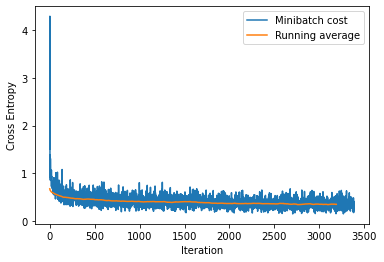

In [20]:
plt.plot(minibatch_loss_list_ft, label='Minibatch cost')
plt.plot(np.convolve(minibatch_loss_list_ft, 
                     np.ones(200,)/200, mode='valid'), 
         label='Running average')

plt.ylabel('Cross Entropy')
plt.xlabel('Iteration')
plt.legend()
plt.show()

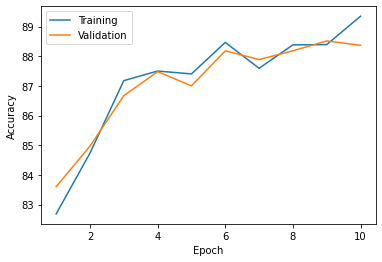

In [21]:
plt.plot(np.arange(1, NUM_EPOCHS+1), train_acc_list_ft, label='Training')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_ft, label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
with torch.set_grad_enabled(False):
    
    train_acc = compute_accuracy(model=model,
                                 data_loader=train_loader,
                                 device=DEVICE)
    
    test_acc = compute_accuracy(model=model,
                                data_loader=test_loader,
                                device=DEVICE)
    
    valid_acc = compute_accuracy(model=model,
                                 data_loader=valid_loader,
                                 device=DEVICE)
    

print(f'Train ACC: {train_acc:.2f}%')
print(f'Validation ACC: {valid_acc:.2f}%')
print(f'Test ACC: {test_acc:.2f}%')

Train ACC: 89.19%
Validation ACC: 89.33%
Test ACC: 87.85%


# AlexNet: from_scratch vs. pretrained

In [23]:
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list_scratch, label='from scratch')
plt.plot(np.arange(1, NUM_EPOCHS+1), valid_acc_list, label='pretrained')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'valid_acc_list_scratch' is not defined